# Config

In [1]:
#VERSION = 'focal_loss-161120200048'
#VERSION = 'release_focal_loss'
VERSION = '10-epoch_final'
OVERWRITE_CHECKPOINT = False    
RECOVER_PAST_TRAINNING = True
TRAIN = False
# Rsp swin t from https://github.com/ViTAE-Transformer/ViTAE-Transformer-Remote-Sensing
# loss function imbalanced classes

import sys, os
RunningInCOLAB = 'google.colab' in sys.modules

BATCH_SIZE = 64
if RunningInCOLAB:
    BATCH_SIZE = 64

FEATURES = 17
IMG_SIZE = 224
LR = 1e-4
LR_STEP_SIZE = 1
GAMMA = 0.9
N_EPOCHS = 10
MODEL_ARCH = ['rsp-swin-t', 'rsp-resnet-50', 'swin_t_IMAGENET', 'resnet50_IMAGENET']

MODEL = 'rsp-swin-t'
#MODEL = 'rsp-resnet-50'


weights_models = {'rsp-swin-t': 'rsp-swin-t-ckpt.pth', 'swin_t_IMAGENET': 'IMAGENET1K_V1',
                      'rsp-resnet-50' : 'rsp-resnet-50-ckpt.pth', 'resnet50_IMAGENET':'' }

weights_filename = weights_models[MODEL]

config = {"BATCH_SIZE": BATCH_SIZE,"IMG_SIZE": IMG_SIZE,"LR": LR,"LR_STEP_SIZE": LR_STEP_SIZE,
          "GAMMA": GAMMA,"N_EPOCHS": N_EPOCHS,"VERSION": VERSION,"PRETRAIN_WEIGHTS": weights_filename}
      

# Set Environment

In [2]:
if RunningInCOLAB:
    from google.colab import drive, files, runtime

    drive.mount('/content/drive', force_remount=True)
    !unzip -n /content/drive/MyDrive/Colab-Notebooks/datasets/planet.zip -d /content/;
    %clear
    checkpoint_path_dir = '/content/drive/MyDrive/Colab-Notebooks/checkpoints/'
    dataset_dir="/content/planet/"
    experiment_results = f'/content/drive/MyDrive/Colab-Notebooks/results/{MODEL}/'
    %mkdir -p ${experiment_results}

else:
    home = os.environ['HOME']
    dataset_dir = home + "/UFMG/Thesis/datasets/planet"
    checkpoint_path_dir = home +'/UFMG/Thesis/Experiments/checkpoints/'
    experiment_results = home + f'/UFMG/Thesis/Experiments/results/{MODEL}_{VERSION}/'
    %mkdir -p ${experiment_results}

results_path = checkpoint_path_dir + f"train_results_{MODEL}_{VERSION}.pkl"
checkpoint_path = checkpoint_path_dir + f"{MODEL}_{VERSION}.pth"
weights_path = checkpoint_path_dir + f"{weights_filename}"          


In [3]:
if RunningInCOLAB:
    %pip install torch torchvision sklearn dill tqdm plotly matplotlib torchinfo opencv-python timm yacs seaborn kaleido
    %clear

In [4]:
path = dataset_dir
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
total_train_files = len(os.listdir(path_train))
print(f"train files: {total_train_files}, "
    f"test files: {len(os.listdir(path_test))}")

train files: 40479, test files: 40669


# Libs

In [5]:
from collections import Counter
from copy import copy, deepcopy
from glob import glob
from matplotlib import pyplot as plt
from PIL import Image
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, precision_recall_fscore_support, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from time import time
from torch import nn, Tensor
from torch.autograd import Variable
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torchvision import transforms, models
from tqdm.notebook import tqdm
import cv2
import dill as pickle
import gc
import numpy as np  # Torch wrapper for Numpy
import os
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import random
import seaborn as sns
import threading
import timm
import torch
import torch.optim as optim

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


In [6]:
def clear_cache():
    if RunningInCOLAB:
        torch.cuda.empty_cache()
    gc.collect()

In [7]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results

    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(1001)

# EDA

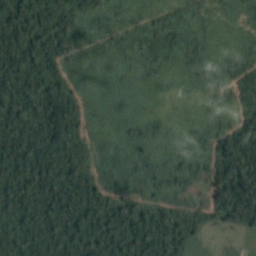

In [8]:
display(Image.open(path_train+'/train_333.jpg').convert("RGB"))

In [9]:
path_class = os.path.join(path, "train_classes.csv")
df_class = pd.read_csv(path_class)
print(df_class.shape)

(40479, 2)


In [10]:
label_list = []
for tag_str in df_class.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
# Histogram of label instances
#df_class[label_list].sum().sort_values().plot.bar()      

# Add onehot features for every label
for label in label_list:
    df_class[label] = df_class['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
df_class.head()

image_name                                       tags  haze  primary  \
0    train_0                               haze primary     1        1   
1    train_1            agriculture clear primary water     0        1   
2    train_2                              clear primary     0        1   
3    train_3                              clear primary     0        1   
4    train_4  agriculture clear habitation primary road     0        1   

   agriculture  clear  water  habitation  road  cultivation  slash_burn  \
0            0      0      0           0     0            0           0   
1            1      1      1           0     0            0           0   
2            0      1      0           0     0            0           0   
3            0      1      0           0     0            0           0   
4            1      1      0           1     1            0           0   

   cloudy  partly_cloudy  conventional_mine  bare_ground  artisinal_mine  \
0       0              0                  0            0               0   
1       0              0                  0            0               0   
2       0              0                  0            0               0   
3       0              0                  0            0               0   
4       0              0                  0            0               0   

   blooming  selective_logging  blow_down  
0         0                  0          0  
1         0                  0          0  
2         0                  0          0  
3         0                  0          0  
4         0                  0          0

In [11]:
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

fig = px.bar(df_tags, x="total", y="tag", orientation="h", color="total",)
title = 'Class distribution'
fig.update_layout(title="Tags distribution", width=600, height=400)
fig.show()
fig.write_image(experiment_results+title+".jpg")

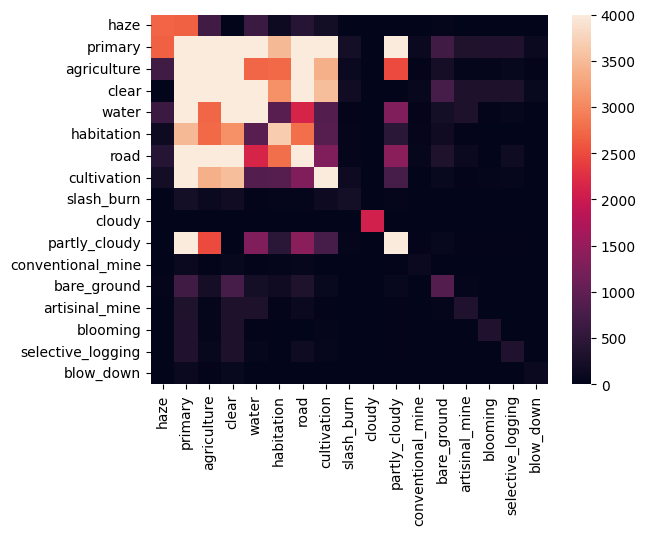

In [12]:
def make_cooccurence_matrix(labels):
    numeric_df = df_class[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    title = 'Co-occurrence matrix'
    fig = sns.heatmap(c_matrix, vmax=4000)
    fig.get_figure().savefig(experiment_results+title+".jpg")
    return c_matrix
    
# Compute the co-ocurrence matrix
c_matrix = make_cooccurence_matrix(label_list)

In [13]:
RARE_CLASSES = ["bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"]
CLIMATE_CLASSES = ["clear", "partly_cloudly", "haze", "cloudy"]

## Train-Test split 80%-20%

In [14]:
df_train, df_val = train_test_split(df_class, test_size=.2)
ds_train_size, ds_val_size = df_train['tags'].size, df_val['tags'].size
for rare_class in RARE_CLASSES:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

train bare_ground: 2.1431% (694)
val bare_ground: 2.0751% (168)

train selective_logging: 0.8399% (272)
val selective_logging: 0.8399% (68)

train artisinal_mine: 0.8152% (264)
val artisinal_mine: 0.9264% (75)

train blooming: 0.8461% (274)
val blooming: 0.7164% (58)

train slash_burn: 0.5373% (174)
val slash_burn: 0.4323% (35)

train blow_down: 0.2501% (81)
val blow_down: 0.2100% (17)

train conventional_mine: 0.2378% (77)
val conventional_mine: 0.2841% (23)



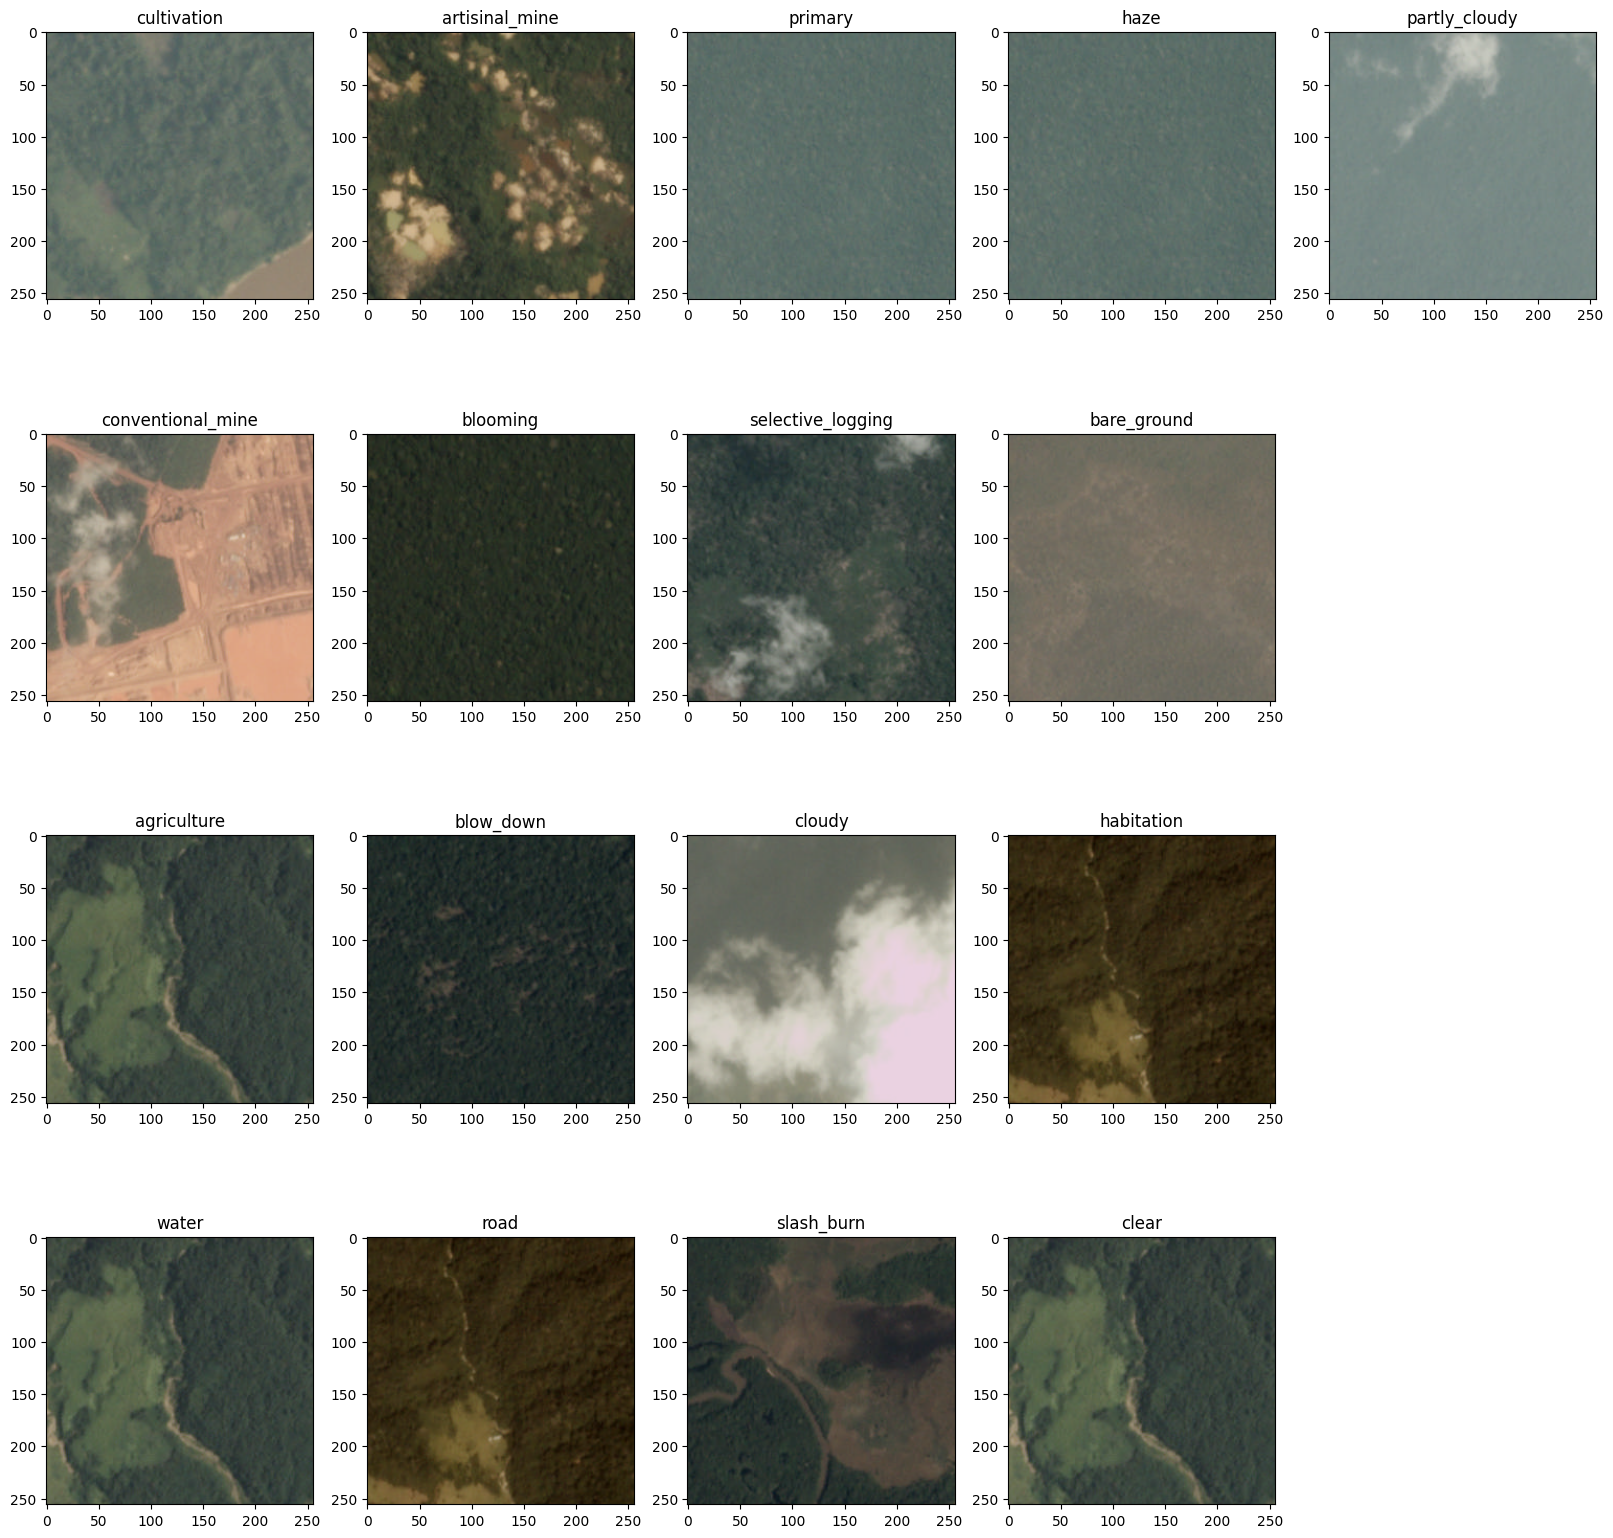

In [15]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()
title = 'Class Sampling'
plt.savefig(experiment_results+title+".jpg")

In [16]:
def load_img(path_file):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype(float)
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    return img

In [17]:
filenames = df_class.image_name.sample(600).values
path_files = [os.path.join(path_train, filename+".jpg")
              for filename in filenames]
X_train_sample = np.vstack([load_img(path_file) for path_file in path_files])
X_train_sample.shape

(600, 30000)

In [18]:
def fetch_img(path_file, h, w):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (h*2, w*2), cv2.INTER_LINEAR)
    return img

/home/vektor/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



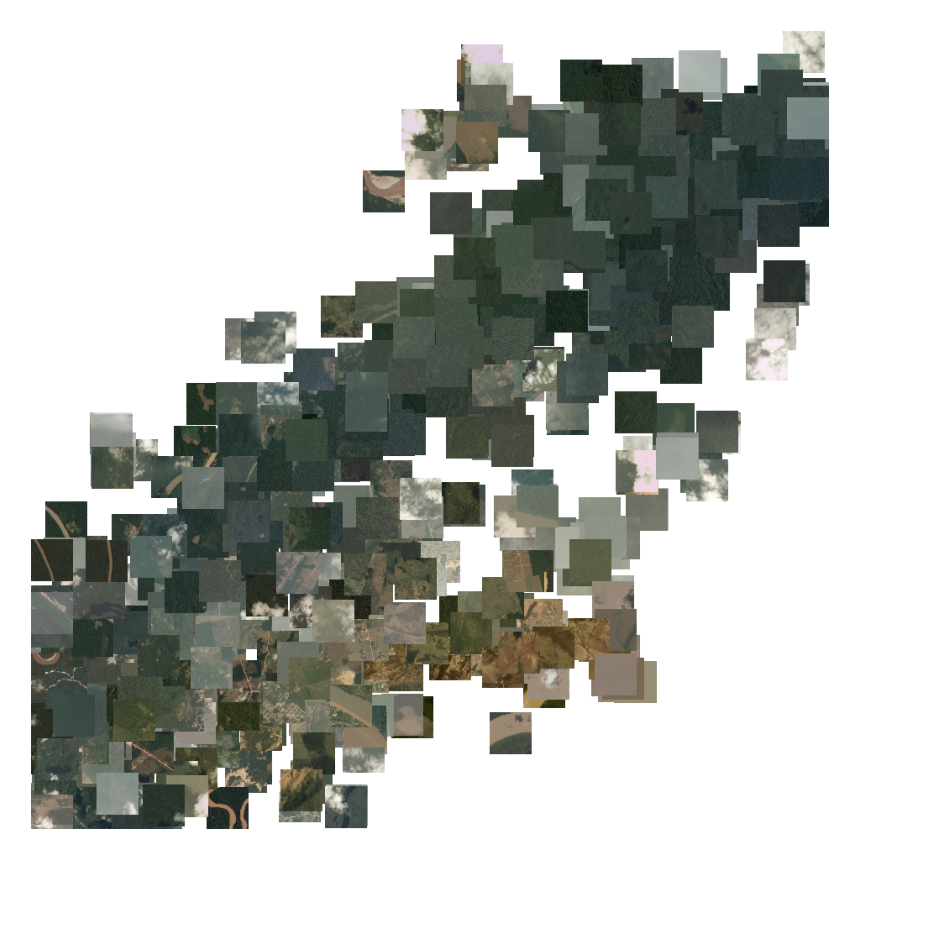

In [19]:
def tsne_analysis():

    tsne = TSNE(
        n_components=2,
        init="random",
        random_state=101,
        method="barnes_hut",
        n_iter=500,
        verbose=0,
    )
    X_embedded = tsne.fit_transform(X_train_sample)

    size_img = 1000
    offset_img = 50
    h = w = int(offset_img / 2)

    X_scaled = (X_embedded - X_embedded.min(0)) / (X_embedded.max(0) - X_embedded.min(0))
    X_scaled = (X_scaled * size_img).astype(int)
    X_scaled = np.clip(X_scaled, offset_img, size_img-offset_img)

    img_tsne = np.ones((size_img+2*offset_img, size_img+2 * offset_img, 3), dtype=np.uint8) * 255
    for idx in range(X_scaled.shape[0]):
        x, y = X_scaled[idx][0], X_scaled[idx][1]
        img = fetch_img(path_files[idx], h, w)
        img_tsne[x-w:x+w, y-h:y+h, :] = img

    fig = plt.figure(figsize=(12, 12))
    plt.axis("off")
    title = 'TSNE Clustering'
    plt.savefig(experiment_results+title+".png")
    return plt.imshow(img_tsne)

tsne_analysis()


# Dataset loader

In [20]:
# create image augmentations
transform_train = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], # Imagenet normalization
        )                                                          # TODO: Normalize from the current dataset
])

transform_val = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
        )
])

In [21]:
class AmazonDatasetError(Exception):
    pass


class AmazonDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform_train
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise AmazonDatasetError(f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise AmazonDatasetError(f"Can't fetch {filename} among {self.paths}")
        image = Image.open(file_path).convert("RGB")
        label = self.ohe_tags[idx]
        return image, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = self.transform(img)
            img.permute(2, 0, 1)
            imgs.append(img[None])
            labels.append(label[None])
        imgs = torch.cat(imgs).float()
        labels = torch.cat(labels).float()
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {ohe_label} - {self.transform(img).shape}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)


In [22]:
def get_data(df_train, df_val):

    encoder = MultiLabelBinarizer()
    ohe_tags_train = torch.tensor(encoder.fit_transform(df_train.list_tags.values))
    ohe_tags_val = torch.tensor(encoder.transform(df_val.list_tags.values))

    ds_train = AmazonDataset(df_train, ohe_tags_train,
                             transform_train, path=path_train)
    ds_val = AmazonDataset(df_val, ohe_tags_val,
                           transform_val, path=path_train)

    sample_weights = ohe_tags_train.shape[0]/ohe_tags_train.sum(axis=0)
    sample_weights = sample_weights.double()
    sampler = torch.utils.data.WeightedRandomSampler(
        sample_weights, len(sample_weights))

    dl_train = DataLoader(
        ds_train,
        batch_size=BATCH_SIZE,
        collate_fn=ds_train.collate_fn,
        # sampler=sampler,
        shuffle=True,
        prefetch_factor=2,
        pin_memory=True,
        num_workers=2,
        drop_last=True

    )
    dl_val = DataLoader(
        ds_val,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=ds_val.collate_fn,
        prefetch_factor=2,
        pin_memory=True,
        num_workers=2,
        drop_last=True
    )

    return ds_train, ds_val, dl_train, dl_val, encoder, ohe_tags_train

In [23]:
ds_train, ds_val, dl_train, dl_val, encoder, ohe_tags_train = get_data(df_train, df_val)
classes = encoder.classes_
classes = list(classes)
def unitest_loader():
  imgs, labels = next(iter(dl_train))
  print(imgs.shape, labels.shape)

  imgs, labels = next(iter(dl_val))
  print(imgs.shape, labels.shape)

#unitest_loader()

### Utils

In [24]:
def load_checkpoint(filename):
    try:
        checkpoint = torch.load(filename, map_location=torch.device(device))
        print(checkpoint.keys())
        epoch = checkpoint['epoch']
        model_state = checkpoint['model']
        optimizer_state = checkpoint['optimizer']
        lr_scheduler_state = checkpoint['lr_scheduler']
        max_accuracy = checkpoint['max_accuracy']
        epoch = checkpoint['epoch']
        #config = checkpoint['config']
        return checkpoint, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy
    except:
        print("Not able to load checkpoint ",filename)


def load_results(filename):
    try:
        results = dict()
        results = pickle.load(open(filename,"rb"))
        score = results['score']
        loss = results['loss']
        y_epochs = results['y']
        Y_thresh = results['Y_thresh']
        configs = results['config']
        epochs = results['epoch']
        max_accuracy = results['max_accuracy']

        return results, score, loss, y_epochs, Y_thresh, configs, epochs, max_accuracy

    except Exception as e:
        print("Not able to load results")
        print(e)  


def remove_file(path):
    if OVERWRITE_CHECKPOINT:
        try:
            os.remove(path)
            print(f"File {path} removed")
            return
        except Exception as e:
            print(e) 
    print(f"Not able to remove {path}")  

def save_overwrite_checkpoints(checkpoint, file):
    remove_file(file)
    torch.save(checkpoint, file)
    print(f"File {file} updated")


def save_overwrite_results(results, file):
    remove_file(file)
    pickle.dump(results, open(file, "wb+"))    
    print(f"File {file} updated")

def print_arch():
  print([module for module in model.modules() if not isinstance(module, nn.Sequential)])
    
def print_weights():
    kl = list()
    #unfreeze_param = ["relative_position_index", "relative_coords_table", "attn_mask", "head", "relative_position_bias_table", "absolute_pos_embed"]
    unfreeze_param = ["head", "layers.3.blocks.1.mlp, layers.3.downsample.norm"]
    unfreeze_param = ["layers.3.blocks.1."]
    #unfreeze_param = ["head"]
    for k, v in model.state_dict().items():
        #v.requires_grad = False
        print(f"{k} requires grad {v.float().requires_grad}")
        for parameter in unfreeze_param:
            if parameter in k:
                freeze=False
                v=v.float()
                print(k,v)
                #v.requires_grad = True 
                print(f"unfreeze {k}")
                break
            freeze=True

        if freeze:
            #v.requires_grad = freeze
            kl.append(k)
            #print( k)  


# Model

## Loading pre-trained weights/checkpoints

In [25]:
if RECOVER_PAST_TRAINNING:
    checkpoint, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy = load_checkpoint(checkpoint_path)
    results, score, loss, y_epochs, Y_thresh, configs, epochs, max_accuracy = load_results(results_path)
    print("recover_training")
else:
    if MODEL == 'resnet50_IMAGENET':
        model = models.resnet.resnet50(weights='IMAGENET1K_V1')
        model_state = model.state_dict()
    elif MODEL == 'swin_t_IMAGENET':
        model = models.swin_transformer.swin_t(weights='IMAGENET1K_V1')
        model_state = model.state_dict()
    else:
        checkpoint, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy = load_checkpoint(weights_path)
    results = {}

dict_keys(['epoch', 'model', 'optimizer', 'loss', 'max_accuracy', 'best_loss_val', 'lr_scheduler', 'config'])
recover_training


In [26]:
def build_model_resnet_50(model_state):
    #https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

    model = models.resnet50()
    model.fc = nn.Sequential(
      nn.Linear(2048, 17), # 512 for resnet18 or 2048 for resnet 50
      nn.Sigmoid()
    )     

    if RECOVER_PAST_TRAINNING:
        info = model.load_state_dict(model_state, strict=True)
        return model.to(device)

    del model_state['fc.weight']
    del model_state['fc.bias']

    info = model.load_state_dict(model_state, strict=False)

    #for param in model.parameters():
    #    param.require_grad = False

    return model.to(device)


if MODEL == 'rsp-resnet-50':
    model = build_model_resnet_50(model_state)
    clear_cache()

In [27]:
def build_model_swan_t(model_state):
    num_classes = 17
    swin_embed_dim = 768

    model = timm.models.swin_tiny_patch4_window7_224()

    if RECOVER_PAST_TRAINNING:
        model.head = nn.Linear(swin_embed_dim, num_classes)
        model = torch.nn.Sequential(model, torch.nn.Sigmoid())
        info = model.load_state_dict(model_state, strict=True)
        clear_cache()
        return model.to(device)

    state_dict = model_state

    # assuming that the head layer has 768 neurons, otherwise change it
    model.head = nn.Linear(swin_embed_dim, num_classes)
    #torch.nn.Sequential(model, torch.nn.Sigmoid())

    model = model.to(device)
    state_dict = model.state_dict()

    # delete relative_position_index since we always re-init it
    relative_position_index_keys = [k for k in state_dict.keys() if "relative_position_index" in k]
    for k in relative_position_index_keys:
        del state_dict[k]

    # delete relative_coords_table since we always re-init it
    relative_position_index_keys = [k for k in state_dict.keys() if "relative_coords_table" in k]
    for k in relative_position_index_keys:
        del state_dict[k]

    # delete attn_mask since we always re-init it
    attn_mask_keys = [k for k in state_dict.keys() if "attn_mask" in k]
    for k in attn_mask_keys:
        del state_dict[k]

    state_dict = model_state
    torch.nn.init.constant_(model.head.bias, 0.)
    torch.nn.init.constant_(model.head.weight, 0.)

    del state_dict['head.weight']
    del state_dict['head.bias']

    info = model.load_state_dict(state_dict, strict=False)
    print(info)
    model.head = nn.Linear(swin_embed_dim, num_classes)
    model = torch.nn.Sequential(model, torch.nn.Sigmoid())
 

    return model.to(device)


if MODEL == 'rsp-swin-t' :
    clear_cache()
    model = build_model_swan_t(model_state)



/home/vektor/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)



# Train setup

In [28]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=0.8, gamma=2, smooth=1):     
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss.to(device)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lr_scheduler = ReduceLROnPlateau(optimizer, cooldown=2, factor=0.1, verbose=True, patience=10)
early_stopper = EarlyStopper(patience=2)
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
sample_weights = ohe_tags_train.shape[0]/ohe_tags_train.sum(axis=0) - 1
sample_weights = sample_weights.double().to(device)
#loss_fn = nn.BCELoss(weight=sample_weights)  # Binary Cross Entropy
#loss_fn = nn.BCELoss()  # Binary Cross Entropy
loss_fn = FocalLoss()
sample_weights

tensor([2.2826e+00, 1.2166e+02, 4.5661e+01, 1.1719e+02, 3.9879e+02, 4.2562e-01,
        1.8241e+01, 4.1956e+02, 8.0785e+00, 1.0082e+01, 1.4104e+01, 4.5450e+00,
        8.0009e-02, 4.0183e+00, 1.1806e+02, 1.8511e+02, 4.5111e+00],
       dtype=torch.float64)

### Batch fit/validate

In [30]:
def fit_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X.to(device))
    batch_loss = loss_fn(Y_hat, Y.to(device))
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach()

    return Y_hat, batch_loss.item()


@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X.to(device))
    batch_loss = loss_fn(Y_hat, Y.to(device))
    Y_hat = Y_hat.detach()

    return Y_hat, batch_loss.item()
# Test batch train

def unit_test_batch_train():
    clear_cache()
    X, Y = next(iter(dl_train))
    model.train()
    optimizer.zero_grad()
    print(X.shape)
    print(Y.shape)
    Y_hat = model(X.to(device))
    Y_hat[Y_hat < 0]
    batch_loss = loss_fn(Y_hat, Y.to(device))
    Y_hat = Y_hat.detach()
    clear_cache()

    
#unit_test_batch_train()

In [31]:
def init_arrays(train_baches_epoch, val_baches_epoch):
    train_baches_epoch, val_baches_epoch = int(train_baches_epoch), int(val_baches_epoch)
    loss = dict()
    loss["train"] = np.zeros((N_EPOCHS,train_baches_epoch))
    loss["val"] = np.zeros((N_EPOCHS,train_baches_epoch))
    lr = np.zeros((N_EPOCHS,train_baches_epoch))
    score = dict()
    score["val"] = np.zeros(N_EPOCHS)
    score["train"] = np.zeros(N_EPOCHS)

    y_epoch = {'train': dict(), 'val': dict()}
    y_epoch["train"]["label"] = torch.zeros((N_EPOCHS, train_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["train"]["pred"] = torch.zeros((N_EPOCHS, train_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["val"]["label"] = torch.zeros((N_EPOCHS, val_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["val"]["pred"] = torch.zeros((N_EPOCHS, val_baches_epoch, BATCH_SIZE, FEATURES))

    return y_epoch, score, loss, lr
    
train_steps, val_steps = ds_train_size//BATCH_SIZE, ds_val_size//BATCH_SIZE
y_epoch, score, loss, lr = init_arrays(train_steps, val_steps)
print(train_steps)
print(y_epoch["train"]["label"][N_EPOCHS-1][train_steps-1][BATCH_SIZE-1][FEATURES-1])

505
tensor(0.)


In [32]:
def eval_score(Y_true:Tensor, Y_pred:Tensor, threshold:float):
    Y_true = Y_true.cpu().numpy().reshape((-1,FEATURES))
    Y_pred = (Y_pred.cpu().numpy() > .2).astype(float).reshape((-1,FEATURES))
    return fbeta_score(Y_true,Y_pred,beta=2, average="samples")

t1, t2 = torch.zeros(FEATURES), torch.zeros(FEATURES)
t1[4], t2[7] = 1, 1
Y_true = torch.cat([t1,t2])
Y_pred = torch.cat([t2,t1])*0.8
print(Y_true)
print(Y_pred)
eval_score(Y_true, Y_pred, 0.5)

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.8000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


0.0

# Train

In [33]:
def train_model(dl_train, dl_val, version, model, optimizer, loss_fn, lr_scheduler, results, checkpoint):
    train_steps, val_steps = ds_train_size//BATCH_SIZE, ds_val_size//BATCH_SIZE

    y_epoch, score, loss, lr = init_arrays(train_steps, val_steps)
    epoch_start = 0
    if results and RECOVER_PAST_TRAINNING:
        train_results = deepcopy(results)
        epoch_start = checkpoint['epoch']
        best_score_val = train_results["score_val"]
        lr_scheduler = checkpoint['lr_scheduler']
        
    Y_val, Y_hat = torch.zeros(FEATURES), torch.zeros(FEATURES)
    best_loss_val, best_score_val = torch.inf, 0
    Y_thresh_val = 0.2
    batch_loss = torch.inf
    for epoch in range(epoch_start, N_EPOCHS):

        for idx, (X, Y) in enumerate(tqdm(dl_train, leave=False)):
            Y_hat, batch_loss = fit_batch(X, Y, model, loss_fn, optimizer)
            loss["train"][epoch][idx] = batch_loss
            y_epoch["train"]["pred"][epoch][idx] = Y_hat
            y_epoch["train"]["label"][epoch][idx] = Y
            lr[epoch][idx] = optimizer.param_groups[0]['lr']
            if idx > 0 and idx % LR_STEP_SIZE == 0:
                avg_loss = loss["train"][epoch][idx-LR_STEP_SIZE:idx+1].mean()
                it_score = eval_score(Y,Y_hat,Y_thresh_val)
                print(f'Train Loss: {avg_loss} score:{it_score}')
                #lr_scheduler.step(metrics=avg_loss)
            #break

        for idx, (X, Y) in enumerate(tqdm(dl_val, leave=False)):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss["val"][epoch][idx] = batch_loss
            y_epoch["val"]["pred"][epoch][idx] = Y_hat
            y_epoch["val"]["label"][epoch][idx] = Y
            #break
        

        score['train'][epoch] = eval_score(y_epoch["train"]["label"][epoch],
                                          y_epoch["train"]["pred"][epoch], Y_thresh_val)
        score['val'][epoch] = eval_score(y_epoch["val"]["label"][epoch],
                                        y_epoch["val"]["pred"][epoch], Y_thresh_val)

        avg_loss_train = loss["train"][epoch].mean()
        avg_loss_val = loss["val"][epoch].mean()
        lr_scheduler.step(metrics=avg_loss_val)
        best_loss_val = avg_loss_val if avg_loss_val < best_loss_val else best_loss_val
        best_score_val = score['val'][epoch] if best_score_val < score['val'][epoch] else best_score_val


        print(
            f"epoch: {epoch}/{N_EPOCHS} -- train loss: {avg_loss_train}, "
            f"val loss: {avg_loss_val}"
            f" -- train fbeta_score: {score['train'][epoch]}, "
            f"val fbeta_score: {score['val'][epoch]}"
        )

        checkpoint = {
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': best_loss_val,
            'max_accuracy': best_score_val,
            'best_loss_val': best_loss_val,
            'lr_scheduler': lr_scheduler.state_dict(),
            'config': config
        }

        results = {
            "loss": loss,
            "score": score,
            "y": y_epoch,
            'epoch': epoch,
            'best_loss_val': best_loss_val,
            'max_accuracy': best_score_val,
            'config': config,
            'Y_thresh' : Y_thresh_val,
            'lr':lr
        }
        
        if avg_loss_val <= best_loss_val:
            save_overwrite_checkpoints(checkpoint, checkpoint_path)
        save_overwrite_results(results, results_path)

        if early_stopper.early_stop(score['val'][epoch]):             
           pass
           #break

        #break

if TRAIN:
    clear_cache()
    train_model(dl_train, dl_val, VERSION, model, optimizer, loss_fn, lr_scheduler, results, checkpoint)


### Log Train progress swin_T

```
Train Loss: 0.020104967703622197 score:0.8060449148538267
Train Loss: 0.00426720313337301 score:0.87485324056954
Train Loss: 0.002242462424140784 score:0.8772800080889052
Train Loss: 0.001780108351545829 score:0.9176663831634209
Train Loss: 0.0015675166655602234 score:0.9004057880436557
Train Loss: 0.0013662092594219552 score:0.8816830153664525
Train Loss: 0.0012697115870973757 score:0.8826952698028308
Train Loss: 0.0010498895811202425 score:0.9144889284993469
Train Loss: 0.0009320785024864299 score:0.918288004462033
Train Loss: 0.0008962463273952205 score:0.8836951218892186
Train Loss: 0.0008977715643273006 score:0.9087920740351088
Train Loss: 0.0007698875903565016 score:0.9363278193586098
Train Loss: 0.0008639674305149745 score:0.9367052339936266
Train Loss: 0.0007801686691480779 score:0.887633350441899
Train Loss: 0.0007284701672277504 score:0.9132509929118868
Train Loss: 0.0007734935310098433 score:0.9370861649584077

epoch: 0/10 -- train loss: 0.002467936027586451, val loss: 0.00016594847426795872 -- train fbeta_score: 0.8921033071919323, val fbeta_score: 0.921966489132311
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl updated

Train Loss: 0.0006589033897222591 score:0.9611800906687127
Train Loss: 0.000709749550291998 score:0.9462327069983398
Train Loss: 0.0007604590735413254 score:0.8994657647805626
Train Loss: 0.0007654889496118431 score:0.9330414725797002
Train Loss: 0.0006453365757836089 score:0.8994850349899062
Train Loss: 0.0005795883635366936 score:0.9221340382712045
Train Loss: 0.0006089212472415379 score:0.9314626712188674
Train Loss: 0.0006536363789270963 score:0.9138576739365871
Train Loss: 0.000643275220007185 score:0.9393569473738226
Train Loss: 0.0005229046256581862 score:0.9270832842718144
Train Loss: 0.0005034102603883273 score:0.9365116369367288
Train Loss: 0.0005885590001144597 score:0.9439456936319259
Train Loss: 0.0005781763048294271 score:0.951573572105845
Train Loss: 0.0005929024149325767 score:0.9102197206876553
Train Loss: 0.0005670609236638543 score:0.9342299627455878
Train Loss: 0.0005554762662335809 score:0.9143629315032663

epoch: 1/10 -- train loss: 0.0006186387592858616, val loss: 0.0001384921869583483 -- train fbeta_score: 0.9233726176091723, val fbeta_score: 0.9214735628621755
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl updated

Train Loss: 0.00048029033895281533 score:0.9367054461343254
Train Loss: 0.00045894843811589863 score:0.9522940189458953
Train Loss: 0.0004993046252732916 score:0.912485125843233
Train Loss: 0.0005099458761716021 score:0.9085111947251598
Train Loss: 0.0005602863497070728 score:0.9272983236915621
Train Loss: 0.0005504120556232069 score:0.9228264461819824
Train Loss: 0.0005654215694390118 score:0.8895374663254341
Train Loss: 0.00047450166734521306 score:0.9309033275256164
Train Loss: 0.00048778658533739225 score:0.947953651522313
Train Loss: 0.00043158839839781 score:0.9502426151297267
Train Loss: 0.00042764074075216004 score:0.9128522174822726
Train Loss: 0.0005678298109541497 score:0.9236111410184139
Train Loss: 0.0004912322699730735 score:0.9212254794732458
Train Loss: 0.0006064393368902647 score:0.922209174863127
Train Loss: 0.0005590357151607261 score:0.9129495025649557
Train Loss: 0.0004885777201589888 score:0.9317062884794015

epoch: 2/10 -- train loss: 0.000507315496181018, val loss: 0.00013122741933474042 -- train fbeta_score: 0.9264495571589898, val fbeta_score: 0.9247754557099553
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl updated

Train Loss: 0.0003837355315842996 score:0.9318022498245475
Train Loss: 0.0004197402283147488 score:0.9297548186993004
Train Loss: 0.0003742685219021364 score:0.9344077369201934
Train Loss: 0.0003993430131700851 score:0.9279166919227062
Train Loss: 0.00047757744440816405 score:0.9324812487460656
Train Loss: 0.0004874851156566893 score:0.9290783805816217
Train Loss: 0.000429597876181135 score:0.9539031469183523
Train Loss: 0.0004507566329501119 score:0.931054514341674
Train Loss: 0.0004713093043274937 score:0.9443074754425858
Train Loss: 0.00045879528765761926 score:0.9405173242706053
Train Loss: 0.0004943319607616192 score:0.9137852632797486
Train Loss: 0.0004327571171621281 score:0.9379922382953094
Train Loss: 0.00041629203042248264 score:0.9268400679595932
Train Loss: 0.0004558349272326356 score:0.9294964112174591
Epoch 00062: reducing learning rate of group 0 to 5.0000e-05.
Train Loss: 0.00040991398488967527 score:0.9091851091578196
Train Loss: 0.00035526134161045775 score:0.9545026552228949

epoch: 3/10 -- train loss: 0.00042848117692202405, val loss: 0.00011405238719186792 -- train fbeta_score: 0.931116537438673, val fbeta_score: 0.9283215147857725
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl updated

Train Loss: 0.00032162863757431264 score:0.9425941073084552
Train Loss: 0.00032103002905064533 score:0.9367662660159758
Train Loss: 0.0003351062900506921 score:0.9364345461671867
Train Loss: 0.0003001783320101939 score:0.9430691957425603
Train Loss: 0.0003428746966810356 score:0.922411287184894
Train Loss: 0.00034460073267485224 score:0.9354236857334709
Train Loss: 0.00031243630585395883 score:0.9387666426051258
Train Loss: 0.0003279986835437857 score:0.935541805773883
Train Loss: 0.00034762515626367063 score:0.9620320075936994
Train Loss: 0.00032748838918538945 score:0.9432785781694353
Train Loss: 0.0002934833793270011 score:0.9240607213002398
Train Loss: 0.0003177918962694915 score:0.9621839457280721
Train Loss: 0.00027833644567327873 score:0.9290499826460304
Train Loss: 0.00028190751923360834 score:0.9408643854081234
Train Loss: 0.0003231627971775109 score:0.9600519746426357
Train Loss: 0.00039711224939486373 score:0.9472787465743538

epoch: 4/10 -- train loss: 0.00032504567584555394, val loss: 0.00012002050266301463 -- train fbeta_score: 0.9369727926698045, val fbeta_score: 0.9274183318313106
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl updated

Train Loss: 0.0002495845658432377 score:0.9414911847913008
Train Loss: 0.00028385598852764815 score:0.9390450796909746
Train Loss: 0.00025307243307789545 score:0.9554404086437484
Train Loss: 0.000256100686167502 score:0.9471048477428505
Train Loss: 0.0002855819027078518 score:0.9292440830318779
Train Loss: 0.0003044975204712471 score:0.9527747604723709
Train Loss: 0.000310476962993327 score:0.934295906894712
Train Loss: 0.00027060261157701814 score:0.8897761144084674
Train Loss: 0.0003533015758054511 score:0.9443355096812088
Train Loss: 0.00030286486106624285 score:0.9430738479530949
Train Loss: 0.00030553693678455365 score:0.9251254400192572
Train Loss: 0.0002997965641571359 score:0.9480105517771201
Epoch 00092: reducing learning rate of group 0 to 2.5000e-05.
Train Loss: 0.0003267601925706972 score:0.9401905104633944
Train Loss: 0.00026542904097661974 score:0.9333175412201389
Train Loss: 0.0002868158978432597 score:0.9526513162083015
Train Loss: 0.0002930767347401519 score:0.945657390683166

epoch: 5/10 -- train loss: 0.00028773007327592747, val loss: 0.00011299487906750199 -- train fbeta_score: 0.9400197438319338, val fbeta_score: 0.9291779777941797
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl updated

Train Loss: 0.00023458367251160165 score:0.9278206829359855
Train Loss: 0.0002615861415125114 score:0.9652594540328145
Train Loss: 0.00021249042178932278 score:0.9629186419606766
Train Loss: 0.00021642412250531056 score:0.9630842652791582
Train Loss: 0.0002277345894629346 score:0.9489168589086352
Train Loss: 0.00021862716159610558 score:0.9251656647765694
Train Loss: 0.00025786295455257075 score:0.9350729699110585
Train Loss: 0.0002298408867171665 score:0.9618320951094206
Train Loss: 0.00020006857988435865 score:0.9378278324315313
Train Loss: 0.00023167738090119054 score:0.9429706937235236
Train Loss: 0.00028156635357112054 score:0.952092858201425
Train Loss: 0.0002275865283609751 score:0.9645910832588465
Train Loss: 0.00022497863533170595 score:0.9413962523266213
Train Loss: 0.00023443084137397818 score:0.931031063376811
Train Loss: 0.00023674728905579315 score:0.945826808128998
Train Loss: 0.0002126993356561739 score:0.949552771052993

epoch: 6/10 -- train loss: 0.00023519537543966135, val loss: 0.00011934084413771397 -- train fbeta_score: 0.9450022027527022, val fbeta_score: 0.92802221685734
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl updated

Train Loss: 0.00023591754025772155 score:0.9566817428695026
Train Loss: 0.00019414797321998424 score:0.9508359146402777
Train Loss: 0.00018984731556678702 score:0.9429918989654538
Train Loss: 0.00020862310597177355 score:0.9037690934236403
Train Loss: 0.00021469575304147457 score:0.9251419868589228
Train Loss: 0.00018424021524673839 score:0.9372490309164228
Train Loss: 0.00023099732026176138 score:0.9666014374140726
Train Loss: 0.00022614006522945278 score:0.9556408645118323
Train Loss: 0.00018282447528632004 score:0.9837359873891485
Train Loss: 0.0002014083941122085 score:0.95335627377086
Train Loss: 0.00020010275024575212 score:0.9435546819737997
Train Loss: 0.00020686565520947858 score:0.9605835293555751
Train Loss: 0.00022528278303422753 score:0.9223316219948138
Train Loss: 0.00025411139523062195 score:0.9443162910499743
Train Loss: 0.00022635633638034755 score:0.9462894699904013
Train Loss: 0.00019822946905473908 score:0.9511058743807148

epoch: 7/10 -- train loss: 0.00021113978816021412, val loss: 0.00012759299690046782 -- train fbeta_score: 0.9466594157855397, val fbeta_score: 0.9290841999472416
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl updated

Train Loss: 0.0001806055964064604 score:0.9463708778966132
Train Loss: 0.00018402540538978252 score:0.9397557147447253
Train Loss: 0.0001721458512850316 score:0.9469712405723835
Train Loss: 0.00017198731380161798 score:0.9598124035868639
Train Loss: 0.00021508381131195252 score:0.9497581027913589
Train Loss: 0.00016151468592016176 score:0.9658038807065581
Train Loss: 0.00016345581459444798 score:0.962742535898921
Train Loss: 0.00017312685503706996 score:0.9560837196366238
Train Loss: 0.00018029353563061675 score:0.960862583852014
Train Loss: 0.00018379343166616895 score:0.9424830802407376
Train Loss: 0.00019187786834194294 score:0.9421671642568892
Train Loss: 0.00015649504019811208 score:0.9539369053881275
Train Loss: 0.00022697776078148895 score:0.9468020514285411
Train Loss: 0.00023999332047570796 score:0.9337585497971528
Train Loss: 0.00020247939673642958 score:0.9338482273436559
Train Loss: 0.00019055704169365908 score:0.955495340449147

epoch: 8/10 -- train loss: 0.00018831684925803215, val loss: 0.00013182958579935724 -- train fbeta_score: 0.9488822414257037, val fbeta_score: 0.9262241985085574
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_10-epoch_final.pkl updated

Train Loss: 0.00018798924570399969 score:0.9586761851812404
Train Loss: 0.00016865902744616653 score:0.9653765137006065
Train Loss: 0.00014021074457559735 score:0.9449584546877987
Train Loss: 0.00015115779035934998 score:0.9678723072431954
Train Loss: 0.00017305476132840398 score:0.9525625160107211
Train Loss: 0.00015535138499540006 score:0.9534675424752309
Train Loss: 0.00012747314652980065 score:0.9698225374481008
Train Loss: 0.000148078528230056 score:0.9448915387775924
Train Loss: 0.0001795521120291068 score:0.9452170596109257
Train Loss: 0.00016670938249820124 score:0.9538472123931925
Train Loss: 0.00018136136843109382 score:0.9537839629881109
Train Loss: 0.00016804001185641204 score:0.9496921059367264
Train Loss: 0.0001546863443969238 score:0.9497710486770301
Train Loss: 0.00017636385981008532 score:0.9541206050705615
Train Loss: 0.00016070695240951835 score:0.9648541796404848
Train Loss: 0.00017433371167205604 score:0.9417363285645888

100%
126/126 [03:01<00:00, 1.78s/it]
```

### Train Progress resnet

In [34]:
if RunningInCOLAB:
    #files.download(results_path)
    #files.download(checkpoint_path)
    #!sleep 600
    runtime.unassign()

###

# Analysis

In [35]:
results, score, loss, y_epochs, Y_thresh, configs, epochs, max_accuracy = load_results(results_path)
checkpoint, best_epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy = load_checkpoint(checkpoint_path)

dict_keys(['epoch', 'model', 'optimizer', 'loss', 'max_accuracy', 'best_loss_val', 'lr_scheduler', 'config'])


## Training statistics

In [36]:
def moving_average(series, window):
    y = np.zeros(len(series) - window)
    std = np.zeros(len(series) - window)
    confidence_interval = np.zeros(len(series) - window)
    for i in range(len(y)):
        y[i] = series[i:i+window].mean()
        std[i] = series[i:i+window].std()
        confidence_interval[i] = series[i:i+window].std()*1.96/np.sqrt(window)
    return y, confidence_interval

moving_average(loss['train'].flatten(), window=10)    

def confidence_interval(series):
    std = series.std(axis=1)
    return std * 1.96/np.sqrt(std.size)

#confidence_interval(loss['val'])

In [50]:
filtered_loss, train_confidence_interval = moving_average(loss['train'].flatten(), window=BATCH_SIZE)

eps = 1e-4
train_lower_bound = filtered_loss - train_confidence_interval
train_lower_bound[train_lower_bound <= 0 ] = eps
val_confidence_interval = confidence_interval(loss['val'])
val_x_axis = np.arange(1,len(loss['train'].mean(axis=1))+1)*ds_train_size//BATCH_SIZE - BATCH_SIZE
fig = go.Figure([
    go.Scatter(
        name='Trainning Loss',
        x=np.arange(1,len(filtered_loss)+1),
        y= filtered_loss,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        name='Upper Bound',
        x=np.arange(1,len(filtered_loss)+1),
        y=filtered_loss + train_confidence_interval,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=np.arange(1,len(filtered_loss)+1),
        y = train_lower_bound,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    ),

    go.Scatter(
        name='Validation Loss',
        x=val_x_axis,
        y = loss['val'].mean(axis=1),
        marker=dict(color="#0F0"),
        line=dict(width=1),
        mode='lines',
        showlegend=True
    ),
    go.Scatter(
        name='Upper Bound',
        x=val_x_axis,
        y=loss['val'].mean(axis=1) + val_confidence_interval,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Validation Lower Bound',
        x=val_x_axis,
        y = loss['val'].mean(axis=1) - val_confidence_interval,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(88, 88, 88, 0.3)',
        fill='tonexty',
        showlegend=False
    )
    
])
title = 'Training Loss Per Minibatch'
fig.update_layout(
    yaxis_title='Log Loss',
    xaxis_title='Mini-batch iteration',
    title='Training loss per minibatch',
    hovermode="x"
)
fig.update_yaxes(type="log")
#fig.update_xaxes(type="log")
fig.update_layout(width=500, height=500)
fig.write_image(experiment_results+title+".jpg")
fig.show()

In [38]:
def eval_epoch_scores(Y_label_eval, Y_pred_eval, thresh):
    batches = Y_label_eval.shape[1]
    epochs = Y_label_eval.shape[0]
    batches_scores = np.zeros((epochs, batches))

    for epoch_idx in range(epochs):
        for batch_idx in range(batches):
            batches_scores[epoch_idx][batch_idx] = eval_score(Y_label_eval[epoch_idx][batch_idx],
                                                Y_pred_eval[epoch_idx][batch_idx], thresh)
    return batches_scores.mean(axis=1), confidence_interval(batches_scores)

#eval_epoch_scores(results['y']['val']["label"], results['y']['val']["pred"], 0.2)                                             

In [39]:
train_score, train_confidence = eval_epoch_scores(results['y']['train']["label"], results['y']['train']["pred"], 0.2)
val_score, val_confidence = eval_epoch_scores(results['y']['val']["label"], results['y']['val']["pred"], 0.2)

In [40]:
fig = go.Figure([
        go.Scatter(
            x=list(range(train_score.size)),
            y=train_score,
            name="score_train",
            error_y_array=train_confidence
        ),
        go.Scatter(
            x=list(range(val_score.size)),
            y=val_score,
            name="score_val",
            error_y_array=val_confidence
        )
    ])
title = 'Training Loss Per Epoch'    
fig.update_layout(
    yaxis_title='Log Loss',
    xaxis_title='Mini-batch iteration',
    title=title,
    hovermode="x",
    width=500, height=500
)
fig.write_image(experiment_results+title+".jpg")



## Classifier evaluation

### Using validation set from best epoch

In [51]:
Y_hat_val = results['y']['val']["pred"][best_epoch].reshape(-1,FEATURES).numpy()
Y_val = results['y']['val']["label"][best_epoch].reshape(-1,FEATURES).numpy()
Y_hat_val.shape

(8064, 17)

In [52]:
pos_probas, neg_probas = [], []
for class_, idx in encoder._cached_dict.items():
    pos_probas.append(Y_hat_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_hat_val[np.where(Y_val[:, idx] == 0), idx].mean())
fig = go.Figure([
    go.Bar(x=list(encoder._cached_dict),
           y=pos_probas, name="Y_hat proba | Y = 1"),
    go.Bar(x=list(encoder._cached_dict),
           y=neg_probas, name="Y_hat proba | Y = 0")
])
title = "Marginal Probabilities Per Class"
fig.update_layout(width=1000, height=500, title=title)
fig.write_image(experiment_results+title+".jpg")
fig.show()


In [55]:
def find_best_thresholds(Y_hat, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in tqdm(range(N_tags)):
        best_score = 0
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_hat_thresh = (Y_hat > threshs).astype(float)
            score = fbeta_score(Y, Y_hat_thresh, beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx

    global_best_score = fbeta_score(
        Y, (Y_hat > best_threshs).astype(float), beta=2, average="samples")
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")
    return best_threshs

best_threshs = find_best_thresholds(Y_hat_val, Y_val)


  0%|          | 0/17 [00:00<?, ?it/s]

threshs: [0.29, 0.07, 0.26, 0.23, 0.12, 0.16, 0.11, 0.15, 0.25, 0.21, 0.19, 0.14, 0.18, 0.17, 0.36, 0.61, 0.15] -- best score: 0.9320404254043384


In [56]:
def classify(probs):
    return (probs > best_threshs).astype(float)

def classify_class(probs, class_idx):
    return (probs[:, class_idx].ravel() > best_threshs[class_idx]).astype(float)
    
#classify(Y_hat_val)
#classify_class(y_pred, 7)

In [57]:
def plot_score_per_tag(threshs):
    class_scores = {}
    classes = encoder.classes_
    for jdx in range(Y_val.shape[1]):
        y_val = Y_val[:, jdx].ravel()
        score = fbeta_score(y_val, classify_class(Y_hat_val, jdx), beta=2)
        class_scores[classes[jdx]] = round(score, 4)

    df_score = pd.DataFrame(dict(
        label=list(class_scores.keys()), score=list(class_scores.values()),
    )).sort_values("score", ascending=True)
    fig = px.bar(df_score, x="label", y="score", color="score")
    fig.update_layout(
        title='Score Per Class Using Optimal Thresholds',
        width=800, height=400
    )
    fig.show()
    fig.write_image(experiment_results+"Score Per Class Using Optimal Thresholds.jpg")
    return df_score

    
df_score = plot_score_per_tag(best_threshs)


In [58]:
df_score

label   score
15         slash_burn  0.0000
3            blooming  0.2583
4           blow_down  0.3614
14  selective_logging  0.4012
2         bare_ground  0.4293
8         cultivation  0.6791
10               haze  0.7559
7   conventional_mine  0.7627
9          habitation  0.7949
16              water  0.8377
13               road  0.8762
1      artisinal_mine  0.8933
0         agriculture  0.8961
6              cloudy  0.9042
11      partly_cloudy  0.9556
5               clear  0.9777
12            primary  0.9912

In [59]:
plot_idx = 0

def get_plot_coords():
    global plot_idx
    row = plot_idx // 4+1
    col = plot_idx % 4+1
    plot_idx +=1
    return col, row

fig = make_subplots(cols=5, rows=5)
for jdx in range(Y_val.shape[1]):
    if not classes[jdx] in RARE_CLASSES:
        #continue
        pass

    y_val = Y_val[:, jdx].ravel()
    y_hat_val_class = classify_class(Y_hat_val, jdx)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val_class).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col, row = get_plot_coords()

    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"],
                         [f"tp: {tp}", f"fp: {fp}"]],
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False
        ),
        col=col, row=row,
    )
    fig.update_xaxes(title=encoder.classes_[jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, row=row, col=col)


fig.update_layout(width=800, height=1000, title="Confusion Matrices")
fig.show()
fig.write_image(experiment_results+"Confusion Matrices.jpg")


In [60]:
y_true = results['y']['val']['label'][best_epoch].reshape((-1,FEATURES)).numpy()
y_pred = results['y']['val']['pred'][best_epoch].reshape((-1,FEATURES)).numpy()

fig1 = go.Figure()
fig1.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1, name='no_skill'
)

fig2 = go.Figure()
fig2.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=0
)

for i in range(y_true.shape[1]):
    y_true_class = y_true[:, i]
    y_pred_class = y_pred[:, i]

    if not classes[i] in RARE_CLASSES:
        continue


    precision, recall, fbeta, support = precision_recall_fscore_support(y_true_class, y_pred_class>0.2, average='binary')
    precision, recall, thresholds= precision_recall_curve(y_true_class, y_pred_class)
    name = f"{classes[i]} (fbeta={fbeta:.3f})"
    fig2.add_trace(go.Scatter(x=recall, y=precision, name=name, mode='lines'))

    fpr, tpr, _ = roc_curve(y_true_class, y_pred_class)
    auc_score = roc_auc_score(y_true_class, y_pred_class, average='macro')
    name = f"{classes[i]} (AUC={auc_score:.3f})"
    fig1.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))
    


fig1.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    #yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=700, height=500,
    title = 'ROC Curve'
)
fig2.write_image(experiment_results+"ROC Curve.jpg")
fig1.show()
fig2.update_layout(
    yaxis_title='Precision',
    xaxis_title='Recall',
    #yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=700, height=500,
    title = 'PR Curve'
)
fig2.write_image(experiment_results+"PR Curve.jpg")
fig2.show()


In [61]:
if RunningInCOLAB:
    #files.download(results_path)
    #files.download(checkpoint_path)
    #!sleep 600
    runtime.unassign()